# How to calculate the confidence interval of the x-intercept in a linear regression?


## Asumptions

* Use the simple regression model $y_i = \alpha + \beta x_i + \varepsilon_i$.
* Errors have normal distribution conditional on the regressors $\epsilon | X \sim \mathcal{N}(0, \sigma^2 I_n)$
* Fit using ordinary least square

## 3 procedures to calculate confidence interval on x-intercept

* Taylor expansion
* Marc in the box method (MIB)
* CAPITANI-POLLASTRI (https://boa.unimib.it/retrieve/handle/10281/43053/64388/DECAPITANI_Pollastri.pdf)


### First order Taylor expansion

Your model is $Y=aX+b$ with estimated standard deviation $\sigma_a$ and $\sigma_b$ on $a$ and $b$ parameters and estimated covariance $\sigma_{ab}$.
You solve 

$$aX+b=0 \Leftrightarrow X= \frac{-b} a.$$

Then the standard deviation $\sigma_X$ on $X$ is given by: 

$$\left( \frac {\sigma_X} X \right)^2 = \left( \frac {\sigma_b} b \right)^2 + \left( \frac {\sigma_a} a \right)^2 - 2 \frac{\sigma_{ab}}{ab}.$$

### MIB

See code from Marc in the box at http://stats.stackexchange.com/questions/221630/how-to-calculate-the-confidence-interval-of-the-x-intercept-in-a-linear-regressi/. 


### CAPITANI-POLLASTRI

CAPITANI-POLLASTRI provides the Cumulative Distribution Function and Density Function for the ratio of two correlated Normal random variables. It can be used to compute confidence interval of the x-intercept in a linear regression. This procedure gives (almost) identical results as the ones from MIB.

Indeed, using ordinary least square and assuming normality of the errors, $\hat\beta \sim \mathcal{N}(\beta, \sigma^2 (X^TX)^{-1})$ (verified) and $\hat{\beta}$'s are correlated (verified). 

The procedure is the following:
* get OLS estimator for $a$ and $b$.
* get the variance-covariance matrix and extract, $\sigma_a, \sigma_b, \sigma_{ab}=\rho\sigma_a\sigma_b$.
* Assume that $a$ and $b$ follow a Bivariate Correlated Normal distribution, $\mathcal{N}(a, b, \sigma_a, \sigma_b, \rho)$. Then the density function and Cumulative Distribution Function of $x_{intercept}= \frac{-b}{a}$ are given by CAPITANI-POLLASTRI. 
* Use the Cumulative Distribution Function of $x_{intercept}= \frac{-b}{a}$ to compute desired quantiles and set a cofidence interval.

## Comparaison of the 3 procedures

The procedures are compared using the following data configuration:
* x <- 1:10
* a <- 20
* b <- -2
* y <- a + b*x + rnorm(length(x), mean=0, sd=1)

10000 diferent sample are generated and analyzed using the 3 methods. The code (R) used to generate and analyze can be found at: https://github.com/adrienrenaud/stackExchange/blob/master/crossValidated/q221630/answer.ipynb 

* MIB and CAPITANI-POLLASTRI give equivalent results.
* First order Taylor expansion differs significantly from the the two other methods.
* MIB and CAPITANI-POLLASTRI suffers from under-coverage. The 68% (95%) ci is found to contain the true value 63% (92%) of the time. 
* First order Taylor expansion suffers from over-coverage. The 68% (95%) ci is found to contain the true value 87% (99%) of the time. 

## Conclusions

The x-intercept distribution is asymmetric. It justify a asymmetric confidence interval. MIB and CAPITANI-POLLASTRI give equivalent results. CAPITANI-POLLASTRI have a nice theorical justification and it gives grounds for MIB. MIB and CAPITANI-POLLASTRI suffers from moderate under-coverage and can be used to set confidence intervals. 


# Code
## The cdf from CAPITANI-POLLASTRI  for the ratio of two correlated Normal random variables.

In [1]:
library(sn)
library(investr)

Loading required package: stats4

Attaching package: ‘sn’

The following object is masked from ‘package:stats’:

    sd



In [2]:
F_W<-function(w,mu_X,mu_Y,sigma_X,sigma_Y,rho) 
            { 
             #if (mu_X, mu_Y)=(0,0) choose a very small value for mu_X and mu_Y 
             if(mu_X==0 & mu_Y==0){ 
                   mu_X<-0.00000000001 
                   mu_Y<-0.00000000001 
                   } 
             #definition of the quantities in expression (2)            
             a    <-  (1/(1-rho^2))^0.5*(mu_Y/sigma_Y-rho*mu_X/sigma_X) 
             b    <-   mu_X/sigma_X 
             t_w  <-  (1/(1-rho^2))^0.5*(sigma_X/sigma_Y*w-rho) 
                 #first addend in expression (5) 
             A   <-  0.5+1/pi*atan(t_w) 
             #second addend in expression (5) 
             B <-  1/pi*atan((b+a*t_w)/(b*t_w-a)) 
             #auxiliary variables 
             h1      <-  (b*t_w-a)/((1+t_w^2)^0.5) 
             h2      <-  (b+a*t_w)/(b*t_w-a) 
             #third and fourth addend in expression(5) 
             C   <-  -2*T.Owen(h1, h2, jmax=170, cut.point=10) 
             D  <-  -1/pi*atan(a/b)+2*T.Owen(b, a/b, jmax=170, cut.point=10) 
             res     <-  A+B+C+D 
             return(res) 
             } 

In [3]:
Quantile_W <- function(q, mu_X,mu_Y,sigma_X,sigma_Y,rho) 
                    { 
                    Quantile <- uniroot(function(w)F_W(w,mu_X,mu_Y,sigma_X,sigma_Y,rho)-q, lower = -1000, upper = 1000, maxiter = 1000) 
                    return(Quantile) 
                    } 

## Compare MIB and CAPITANI-POLLASTRI with same setup as in stackexchange

::: investr             ci: 9.869635 10.22726 
::: Marc in the box     ci: 9.86987 10.22022 
::: CAPITANI-POLLASTRI  ci: 9.87172 10.22489

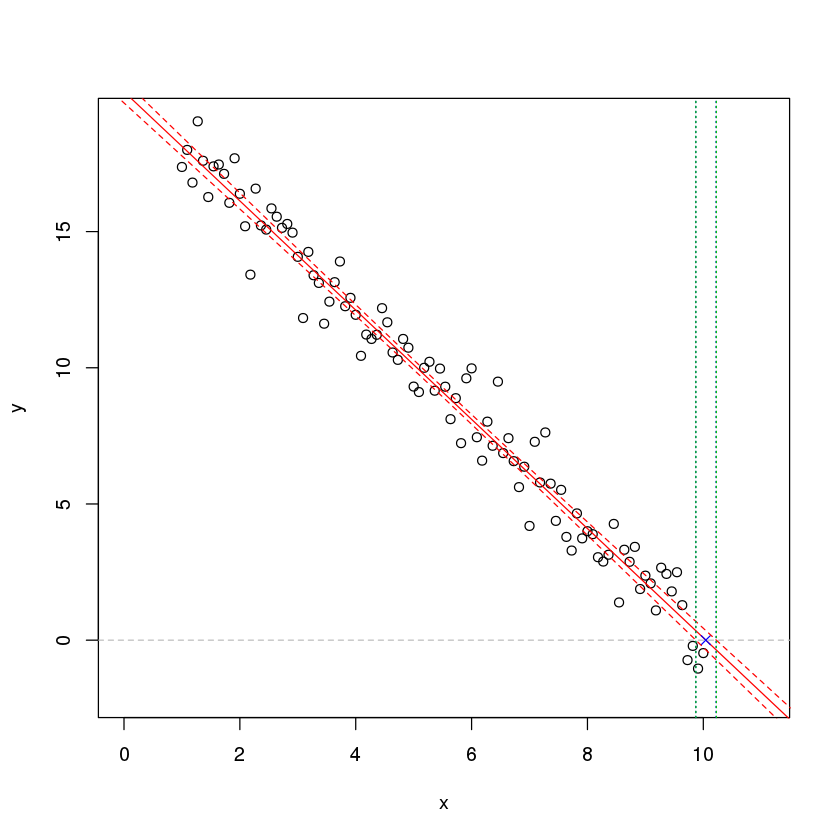

In [48]:
set.seed(1)
#x <- 1:10
x <- seq(1,10, length.out=100)
a <- 20
b <- -2
y <- a + b*x + rnorm(length(x), mean=0, sd=1)

cl = 0.95
n_sigma = qnorm((1+cl)/2)
upr_q = (1+cl)/2
lwr_q = (1-cl)/2

fit <- lm(y ~ x)
XINT <- -coef(fit)[1]/coef(fit)[2]

plot(y ~ x, xlim=c(0, XINT*1.1), ylim=c(-2,max(y)))
abline(h=0, lty=2, col=8); abline(fit, col=2)
points(XINT, 0, col=4, pch=4)
newdat <- data.frame(x=seq(-2,12,len=1000))

# CI
pred <- predict(fit, newdata=newdat, se.fit = TRUE) 
newdat$yplus <-pred$fit + n_sigma*pred$se.fit 
newdat$yminus <-pred$fit - n_sigma*pred$se.fit 
lines(yplus ~ x, newdat, col=2, lty=2)
lines(yminus ~ x, newdat, col=2, lty=2)

# approximate CI of XINT
lwr <- newdat$x[which.min((newdat$yminus-0)^2)]
upr <- newdat$x[which.min((newdat$yplus-0)^2)]
abline(v=c(lwr, upr), lty=3, col=4)

# from CAPITANI-POLLASTRI
v <- vcov(fit)
sigma_intercept <- sqrt(v[1,1])
sigma_slope <- sqrt(v[2,2])
rho <- v[2,1]/(sigma_slope*sigma_intercept)
slope <- coef(fit)[2]
intercept <- coef(fit)[1]

qlwr <- Quantile_W(lwr_q, -slope, intercept, sigma_slope, sigma_intercept, -rho)
cp_lwr <- qlwr$root
qupr = Quantile_W(upr_q, -slope, intercept, sigma_slope, sigma_intercept, -rho)
cp_upr <- qupr$root

abline(v=c(cp_lwr, cp_upr), lty=3, col=3)

# from investr
res_investr <- calibrate(fit, y0=0, interval="inversion", level=cl,  mean.response=TRUE)


cat('::: investr             ci:', res_investr$lower, res_investr$upper, '\n')
cat('::: Marc in the box     ci:', lwr, upr, '\n')
cat('::: CAPITANI-POLLASTRI  ci:', cp_lwr, cp_upr)

## Compare MIB and CAPITANI-POLLASTRI on 10000 different samples

In [72]:
run_exp<-function(cl=0.95){
    n_sigma = qnorm((1+cl)/2)
    upr_q = (1+cl)/2
    lwr_q = (1-cl)/2
    
    #x <- 1:10
    x <- seq(1,10, length.out=100)
    a <- 20
    b <- -2
    y <- a + b*x + rnorm(length(x), mean=0, sd=1)

    fit <- lm(y ~ x)
    XINT <- -coef(fit)[1]/coef(fit)[2]

    newdat <- data.frame(x=seq(-2,12,len=1000))

    # CI
    pred <- predict(fit, newdata=newdat, se.fit = TRUE) 
    newdat$yplus <-pred$fit + n_sigma*pred$se.fit 
    newdat$yminus <-pred$fit - n_sigma*pred$se.fit 

    # approximate CI of XINT
    lwr <- newdat$x[which.min((newdat$yminus-0)^2)]
    upr <- newdat$x[which.min((newdat$yplus-0)^2)]

    # CI from CAPITANI-POLLASTRI
    v <- vcov(fit)
    sigma_intercept <- sqrt(v[1,1])
    sigma_slope <- sqrt(v[2,2])
    rho <- v[2,1]/(sigma_slope*sigma_intercept)
    slope <- coef(fit)[2]
    intercept <- coef(fit)[1]

    qlwr <- Quantile_W(lwr_q, -slope, intercept, sigma_slope, sigma_intercept, -rho)
    cp_lwr <- qlwr$root
    qupr = Quantile_W(upr_q, -slope, intercept, sigma_slope, sigma_intercept, -rho)
    cp_upr <- qupr$root
    
    # CI from Taylor expansion
    sigma_te <- sqrt( (intercept/slope)**2 * ((sigma_slope/slope)**2 + (sigma_intercept/intercept)**2 - (sigma_slope*sigma_intercept*rho)/(slope*intercept)))
    te_lwr = XINT - n_sigma * sigma_te
    te_upr = XINT + n_sigma * sigma_te
    
    return(list(XINT, slope, intercept, lwr, upr, cp_lwr, cp_upr, te_lwr, te_upr))
}

In [73]:
set.seed(1)
n_exp <- 10000
cl = 0.95

v_XINT <- c()
v_slope <- c()
v_intercept <- c()
v_lwr <- c()
v_upr <- c()
v_cp_lwr <- c()
v_cp_upr <- c()
v_te_lwr <- c()
v_te_upr <- c()

for (i in 1:n_exp){
    res <- unlist(run_exp(cl))
    v_XINT[i] <- res[1]
    v_slope[i] <- res[2]
    v_intercept[i] <- res[3]
    v_lwr[i] <- res[4]
    v_upr[i] <- res[5]
    v_cp_lwr[i] <- res[6]
    v_cp_upr[i] <- res[7]
    v_te_lwr[i] <- res[8]
    v_te_upr[i] <- res[9]
}

In [74]:
df <- data.frame(v_XINT, v_slope, v_intercept, v_lwr, v_upr, v_cp_lwr, v_cp_upr, v_te_lwr, v_te_upr)

In [75]:
ci_coverage <-function(x){
    if ( (10. > x[lwr] ) & (10. < x[upr] ) ){
        return(1)
    }
    else{
        return(0)
    }
}

In [76]:
lwr = which(names(df)=='v_lwr')
upr = which(names(df)=='v_upr')
df$mib_coverage = apply(df, 1, ci_coverage)

In [77]:
lwr = which(names(df)=='v_cp_lwr')
upr = which(names(df)=='v_cp_upr')
df$cp_coverage = apply(df, 1, ci_coverage)

In [78]:
lwr = which(names(df)=='v_te_lwr')
upr = which(names(df)=='v_te_upr')
df$te_coverage = apply(df, 1, ci_coverage)

## Coverage

In [79]:
cat('::: Marc in the box coverage   :',sum(df$mib_coverage)/n_exp, '\n')
cat('::: CAPITANI-POLLASTRI coverage:',sum(df$cp_coverage)/n_exp, '\n')
cat('::: Taylor expansion coverage  :',sum(df$te_coverage)/n_exp, '\n')

::: Marc in the box coverage   : 0.9474 
::: CAPITANI-POLLASTRI coverage: 0.9478 
::: Taylor expansion coverage  : 0.9994 


## Test normality for $a$, $b$, and $\frac{-b}{a}$


	Shapiro-Wilk normality test

data:  df[1:5000, ]$v_XINT
W = 0.99917, p-value = 0.01625


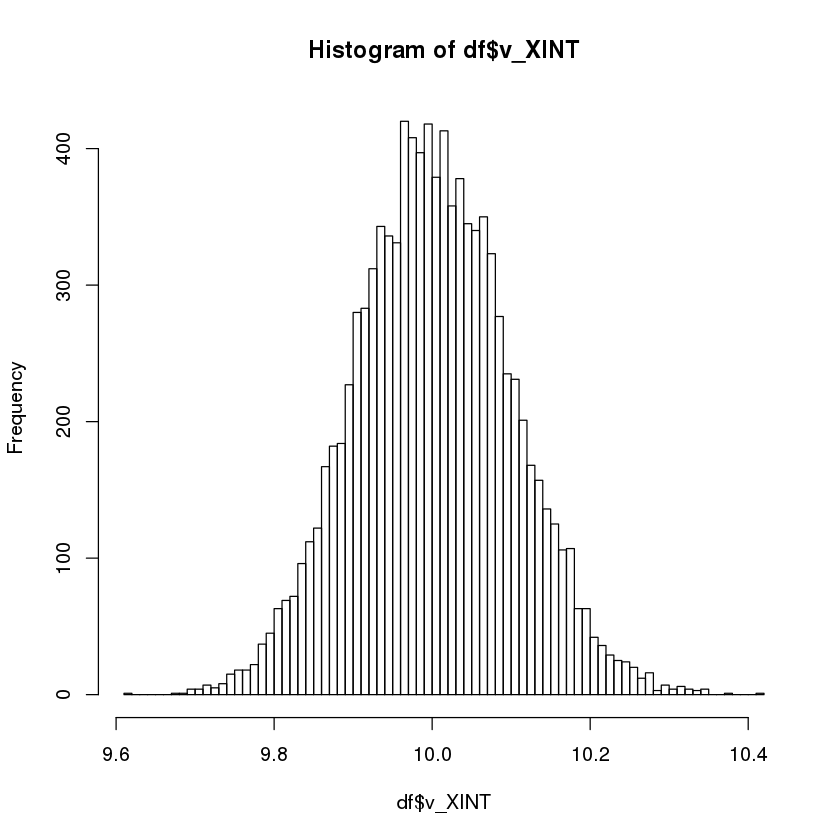

In [80]:
hist(df$v_XINT, 100)
shapiro.test(df[1:5000,]$v_XINT)


	Shapiro-Wilk normality test

data:  df[1:5000, ]$v_slope
W = 0.99955, p-value = 0.2989


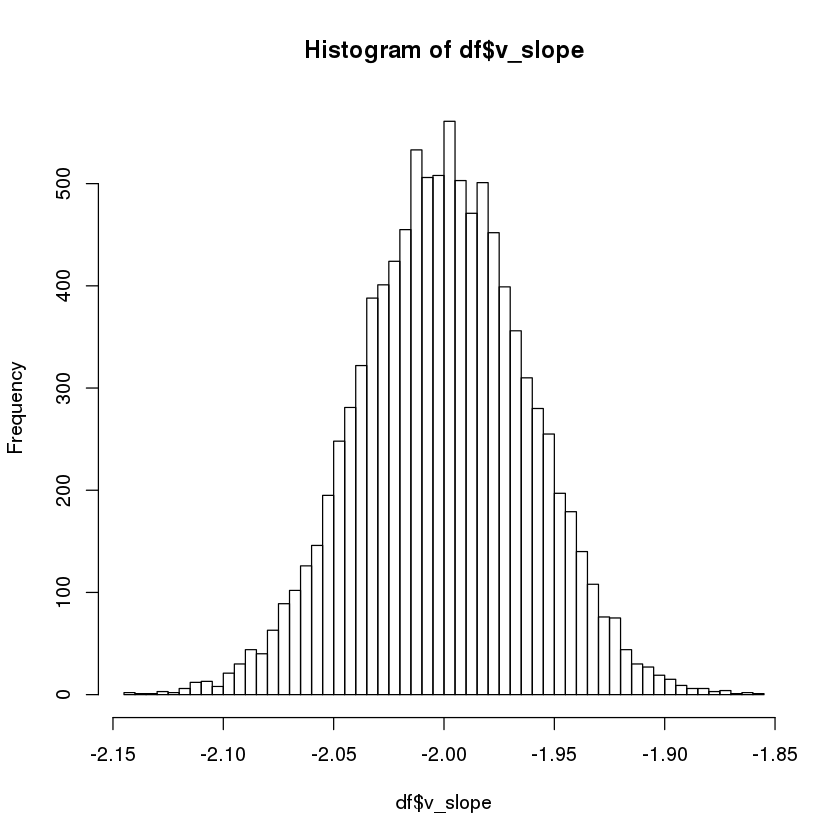

In [81]:
hist(df$v_slope, 100)
shapiro.test(df[1:5000,]$v_slope)


	Shapiro-Wilk normality test

data:  df[1:5000, ]$v_intercept
W = 0.99965, p-value = 0.5583


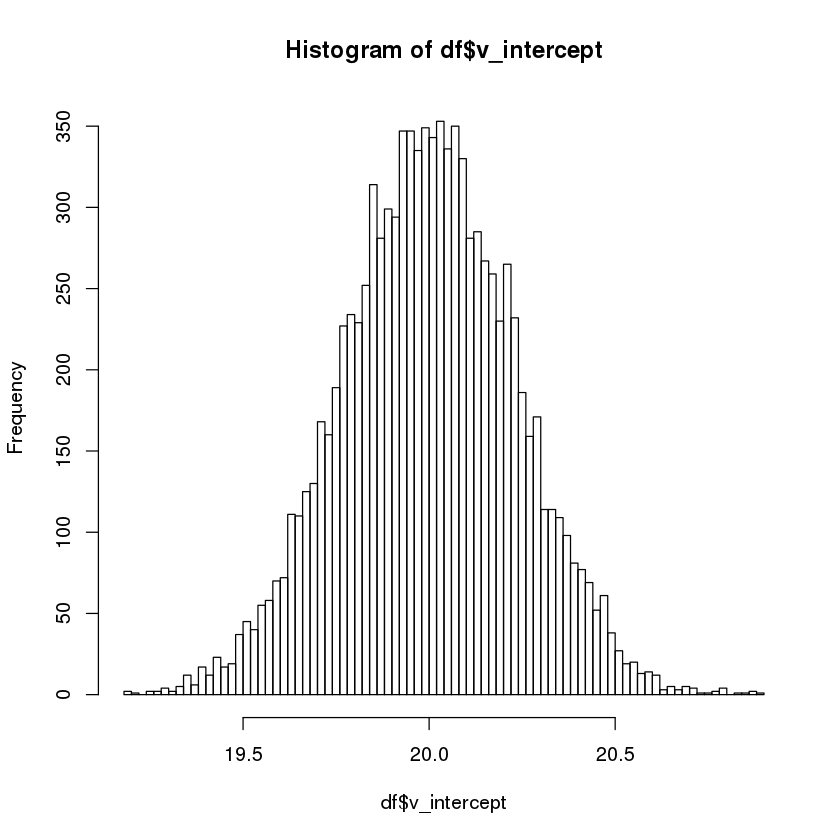

In [82]:
hist(df$v_intercept, 100)
shapiro.test(df[1:5000,]$v_intercept)

[1] -0.9030406

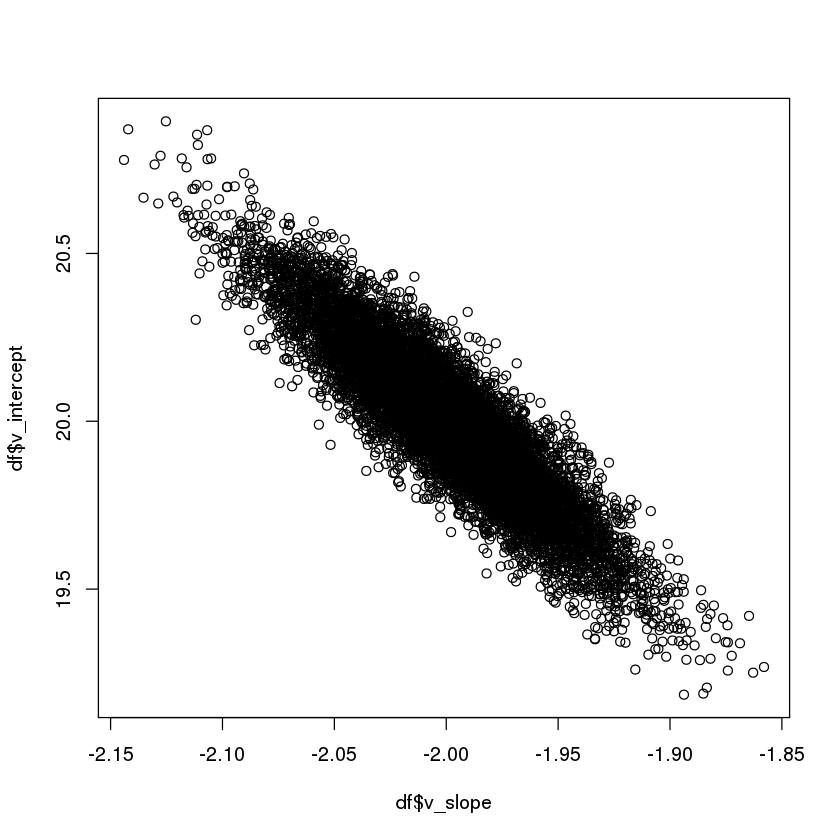

In [83]:
plot(df$v_slope, df$v_intercept)
cor(df$v_slope, df$v_intercept)

In [84]:
a=seq(1,10, length.out=10)

In [85]:
b=1:10

In [86]:
typeof(b)

[1] "integer"

In [87]:
b

[1]  1  2  3  4  5  6  7  8  9 10

In [88]:
a

[1]  1  2  3  4  5  6  7  8  9 10